In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\PROJECT\data\processed\features_ready.csv")

for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)


df.head()


,Timestamp,Age,state,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,Country_Sweden,Country_Switzerland,Country_Thailand,Country_United Kingdom,Country_United States,Country_Uruguay,Country_Zimbabwe,self_employed_Yes,family_history_Yes,Age_scaled
0,2024-08-27 11:29:31,37.0,IL,Yes,Often,6-25,No,Yes,Yes,Not sure,...,0,0,0,0,1,0,0,0,0,0.691282
1,2024-08-27 11:29:37,44.0,IN,No,Rarely,More than 1000,No,No,Don't know,No,...,0,0,0,0,1,0,0,0,0,1.666519
2,2024-08-27 11:29:44,32.0,CA,No,Rarely,6-25,No,Yes,No,No,...,0,0,0,0,0,0,0,0,0,-0.005316
3,2024-08-27 11:29:46,31.0,CA,Yes,Often,26-100,No,Yes,No,Yes,...,0,0,0,1,0,0,0,0,1,-0.144635
4,2024-08-27 11:30:22,31.0,TX,No,Never,100-500,Yes,Yes,Yes,No,...,0,0,0,0,1,0,0,0,0,-0.144635


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['at_risk'])
y = df['at_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [3]:
import numpy as np
cols_to_drop = [col for col in df.columns if df[col].dtype == 'object']
df = df.drop(columns=cols_to_drop, errors='ignore')

for col in df.columns:
    if np.issubdtype(df[col].dtype, np.datetime64):
        df = df.drop(columns=[col])

df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

print("Remaining dtypes:")
print(df.dtypes.head(20))


Remaining dtypes:
Age                          float64
at_risk                        int64
Gender_Male                    int64
Gender_a little about you      int64
Gender_agender                 int64
Gender_all                     int64
Gender_androgyne               int64
Gender_cis female              int64
Gender_cis male                int64
Gender_cis man                 int64
Gender_cis-female/femme        int64
Gender_enby                    int64
Gender_femail                  int64
Gender_femake                  int64
Gender_female (cis)            int64
Gender_female (trans)          int64
Gender_fluid                   int64
Gender_genderqueer             int64
Gender_guy (-ish) ^_^          int64
Gender_mail                    int64
dtype: object


              precision    recall  f1-score   support

           0       0.63      0.73      0.67       125
           1       0.68      0.57      0.62       127

    accuracy                           0.65       252
   macro avg       0.65      0.65      0.65       252
weighted avg       0.66      0.65      0.65       252



<Axes: >

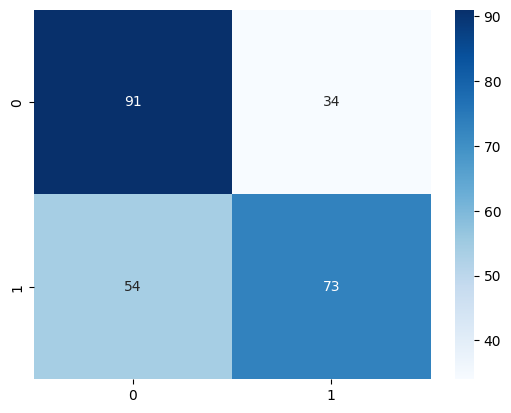

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


X = df.drop(columns=['at_risk'])
y = df['at_risk']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")

In [5]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("RF Test Accuracy:", rf.score(X_test, y_test))

xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)
print("XGB Test Accuracy:", xgb.score(X_test, y_test))


RF Test Accuracy: 0.6428571428571429


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:05:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB Test Accuracy: 0.6626984126984127


AUC: 0.6661732283464566


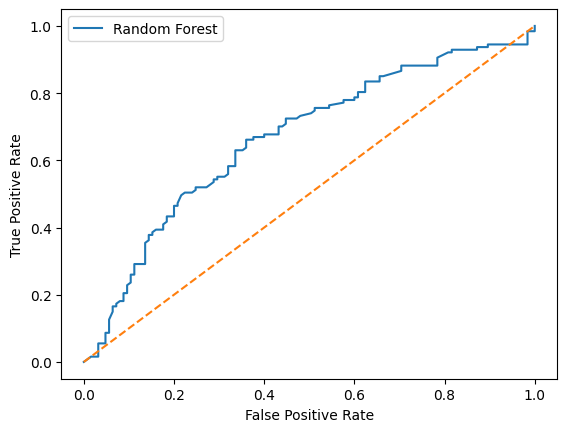

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


y_prob = rf.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


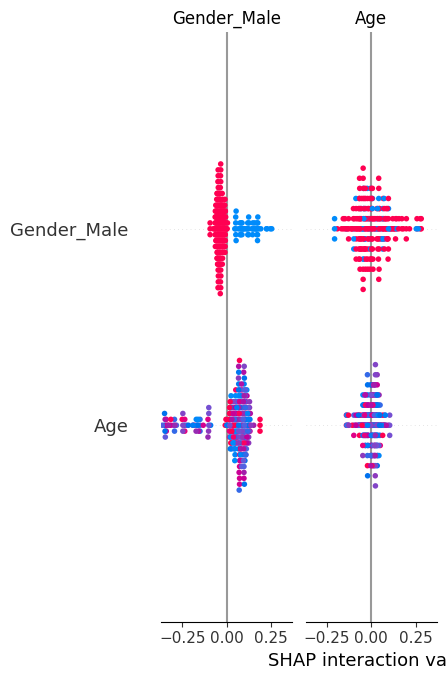

In [12]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)   
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)



In [13]:
import joblib

joblib.dump(rf, "models/random_forest.pkl")


['models/random_forest.pkl']

In [14]:

y_prob = rf.predict_proba(X_test)[:,1]
wellness_score = (1 - y_prob) * 100
df_results = X_test.copy()
df_results['Wellness_Score'] = wellness_score
df_results['Predicted_Risk'] = rf.predict(X_test)

df_results.head()


,Age,Gender_Male,Gender_a little about you,Gender_agender,Gender_all,Gender_androgyne,Gender_cis female,Gender_cis male,Gender_cis man,Gender_cis-female/femme,...,Country_Thailand,Country_United Kingdom,Country_United States,Country_Uruguay,Country_Zimbabwe,self_employed_Yes,family_history_Yes,Age_scaled,Wellness_Score,Predicted_Risk
754,36.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.551962,60.414523,0
936,42.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1.387880,78.769697,0
0,37.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.691282,44.166667,1
318,22.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,-1.398511,4.150000,1
624,31.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,-0.144635,21.811905,1


In [15]:
def generate_alert(row):
    alerts = []
    if row['Age_scaled'] > 1.5:
        alerts.append("You may be working long hours at an older age — consider balancing workload.")
    if 'sleep_hours' in row and row['sleep_hours'] < 6:
        alerts.append("Your average sleep is low — consider prioritizing rest.")
    if 'screen_time' in row and row['screen_time'] > 8:
        alerts.append("High screen time detected — consider reducing exposure before bed.")
    return alerts

df_results['Alerts'] = df_results.apply(generate_alert, axis=1)


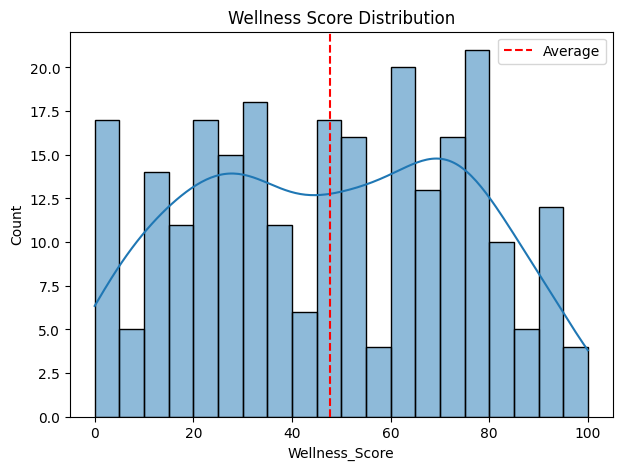

In [16]:
plt.figure(figsize=(7,5))
sns.histplot(df_results['Wellness_Score'], bins=20, kde=True)
plt.axvline(df_results['Wellness_Score'].mean(), color='red', linestyle='--', label="Average")
plt.title("Wellness Score Distribution")
plt.legend()
plt.show()


In [18]:
df_results.to_csv(r"C:\Users\HP\OneDrive\Desktop\PROJECT\data\processed/wellness_scores.csv", index=False)